In [0]:
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
from urllib.request import Request, urlopen
import numpy as np
from skimage.util import view_as_windows as vaw
import tensorflow as tf
import os, sys
import glob
from random import random
from google.colab import drive

In [0]:
try:
  import tflearn
except ImportError:
  !pip3 install -q tflearn
  import tflearn

In [0]:
try:
  import progressbar
except ImportError:
  !pip3 install -q progressbar2
  from progressbar import ProgressBar

In [0]:
from tflearn.data_utils import to_categorical, pad_sequences
from tflearn.layers.recurrent import lstm
from tflearn.layers.core import fully_connected
from tflearn.layers.embedding_ops import embedding as emb

In [5]:
drive.mount('/content/drive')
os.chdir('drive/My Drive/Proteins2018/Models')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
uniprot_keyword = 'artemisinin' # what to query uniprot for
num_consecutive_seqs = 65  # how many substrings to look at at one time
string_len = 1  # how many amino acids to take for each substring
uniprot_limit = 2000 # how many proteins to get for each class from uniprot
n_val = int((uniprot_limit*2) * 0.2)
emb_length = 50

# how many amino acids to skip during cutting when moving to next cut.
# if this number is 1, it just moves to the next one.
stride = 1

save_name = '{}_{}_{}_{}_{}'.format(num_consecutive_seqs, string_len, stride, uniprot_keyword, emb_length)

In [0]:
def install_tensorboard_dep():
  '''This function installs the necessary software to get tensorboard
     working on colaboratory.'''
  
  if 'ngrok-stable-linux-amd64.zip' not in os.listdir(os.getcwd()):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
    os.system('n')
    
  return


def start_tensorboard():
  '''This function starts tensorboard so you can visualize training.'''
  
  LOG_DIR = os.getcwd()
  get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))
  get_ipython().system_raw('./ngrok http 6006 &')
  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
  "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
  
  return

In [0]:
def get_uniprot_data(kw, numxs):
    '''Goes to the uniprot website and searches for 
       data with the keyword given. Returns the data 
       found up to limit elements.'''

    kws = [kw, 'NOT+' + kw]
    Protein_data = {}
            
    for i in range(2):
        kw = kws[i]
        url1 = 'http://www.uniprot.org/uniprot/?query='
        url2 = '&columns=sequence&format=tab&limit='+str(numxs)
        query_complete = url1 + kw + url2
        request = Request(query_complete)
        response = urlopen(request)
        data = response.read()
        data = str(data, 'utf-8')
        data = data.split('\n')
        data = data[1:-1]
        Protein_data[str(i)] = list(map(lambda x:x.lower(),data))

    x = Protein_data['0'] + Protein_data['1']
    y = [0] * (numxs * 2)
    y[:len(y)//2] = [y[n] + 1. for n in range(len(y)//2)]
    print(y)
        
    return x, y

In [0]:
def process_strings(c):
    '''Takes in a list of sequences c and turns each one
       into a list of numbers and pads short ones.'''
  
    lengths = 0
    X = []
            
    for  m, seq in enumerate(c):
        lengths += len(c)
        x = [] 
        for letter in seq:
            x.append(max(ord(letter)-97, 0))
        
        X.append(x)
        
    print('The average length was {}'.format(lengths/(m+1)))
        
    return X

In [0]:
def cut_strings(seqs, labels, cut_len, num_substrings, stride=1):
  '''Takes in a bunch of sequences in seqs and labels for each one in
     labels. Cuts each sequence to cut_len amino acids while moving over
     stride amino acids. Stacks num_substrings amount of these sub-sequences
     on top of each other for the lstm.'''
  
  x = np.zeros([0, num_substrings, cut_len])
  y = np.zeros([0, ])
  
  bar = ProgressBar()
  
  for i, seq in bar(enumerate(seqs)):
    pad_seq = np.pad(np.asarray(seq), 
                     (num_substrings-1, num_substrings-1), 
                     'constant', 
                     constant_values=23.)
    
    x_cut = vaw(pad_seq, (cut_len))
    
    if stride > 1:
      x_cut = x_cut[::stride, ...]
    
    try:
      x_cut = vaw(x_cut, (num_substrings, cut_len))
    except ValueError:
      continue
    
    x = np.concatenate((x, x_cut[:, 0, ...]), 0)
    label = np.full([x_cut.shape[0], ], labels[i])
    y = np.concatenate((y, label))
    
  return x, y

In [0]:
def split_train_test(x, y):
  x_test, y_test = [], []
  for i, seq in enumerate(x):
    if random() > 0.8:
      x_test.append(seq)
      y_test.append(y[i])
      del x[i]
      del y[i]
      
  return x, y, x_test, y_test

In [12]:
# call the get_uniprot_data function to get data and labels
#X, Y = get_uniprot_data(uniprot_keyword, uniprot_limit)

124


In [0]:
no_bind_file = open('NoBindProteins.txt', 'r')
X = no_bind_file.readlines()
Y = [0] * len(X)

In [0]:
bind_file = open('BindProteins.txt', 'r')
X1 += bind_file.readlines()
Y += [1] * len(X1)
X += X1

In [20]:
# call the process_strings function to turn sequences of letters into sequences of numbers
X = process_strings(X)

The average length was 496.0


In [0]:
X, Y, X_test, Y_test = split_train_test(X, Y)
np.save(save_name + '_data.npy', np.asarray(X_test))
np.save(save_name + '_labels.npy', np.asarray(Y_test))

In [23]:
X, Y = cut_strings(X, Y, string_len, num_consecutive_seqs, stride)
#X_test, Y_test = cut_strings(X_test, Y_test, string_len, num_consecutive_seqs, stride)

| |                       #                         | 408 Elapsed Time: 0:00:07


In [24]:
print(X.shape)
Y.shape

(263063, 65, 1)


(263063,)

In [0]:
Y = tflearn.data_utils.to_categorical(Y, 2)

In [0]:
tf.reset_default_graph()

In [0]:
install_tensorboard_dep()

In [28]:
start_tensorboard()

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [0]:
net_in = tflearn.input_data([None, num_consecutive_seqs, string_len])

emb_layer = emb(net_in[..., 0], 26, emb_length)

emb_norm = tflearn.normalization.batch_normalization(emb_layer)

layer1 = lstm(emb_norm, 300, return_seq=True)

layer2 = lstm(layer1, 300, return_seq=True)

layer3 = lstm(layer2, 300, return_seq=True)

layer4 = lstm(layer3, 300, return_seq=True)

layer5 = lstm(layer4, 300)

fc1 = fully_connected(layer5, 150, activation='tanh')
out = fully_connected(fc1, 2, activation='softmax')

In [30]:
net = tflearn.regression(out, optimizer='adam', learning_rate=0.0001,
                         loss='categorical_crossentropy')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
model = tflearn.DNN(net, tensorboard_verbose=0, tensorboard_dir=os.getcwd())

In [32]:
model.fit(X, Y, validation_set=0.2, show_metric=True,
          batch_size=300, n_epoch=6, run_id=save_name)

Training Step: 1624  | total loss: 0.06568 | time: 105.234s
| Adam | epoch: 003 | loss: 0.06568 - acc: 0.9742 -- iter: 066000/210450


KeyboardInterrupt: ignored

In [33]:
model.save(save_name)

INFO:tensorflow:/content/drive/My Drive/Proteins2018/Models/65_1_1_artemisinin_50 is not in all_model_checkpoint_paths. Manually adding it.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


## Analysis

In [0]:
def makeROC(model, data, labels):
  thresholds = np.arange(0., 1.0, 0.1)
  roc = np.zeros([thresholds.size, 2])
  
  for j in range(thresholds.size):
    threshold = thresholds[j]
    confMat = np.zeros([2, 2])
    bar = ProgressBar()
    data_subsample = np.random.randint(0, data.shape[0], int(data.shape[0] * .1))
    data_new, labels_new = data[data_subsample, ...], labels[data_subsample]
    
    for i in bar(range(data_new.shape[0])):
      d, l = data_new[i, :], int(labels_new[i])
      prob = model.predict(d[None, ...])[0, 1]
      prob = int(prob > threshold)
      confMat[l, prob] += 1.
      
    tp = confMat[1, 1] / np.sum(confMat, 1)[1]
    fp = confMat[0, 1] / np.sum(confMat, 1)[0]
    
    roc[j, 0], roc[j, 1] = tp, fp
    
  return roc

In [35]:
X_test1, Y_test1 = cut_strings(X_test, Y_test, string_len, num_consecutive_seqs, stride)

| |   #                                              | 86 Elapsed Time: 0:00:00


In [36]:
print(X_test1.shape, Y_test1.shape)

(48368, 65, 1) (48368,)


In [37]:
ROC = makeROC(model, X_test1, Y_test1)

100% (4836 of 4836) |####################| Elapsed Time: 0:05:50 Time:  0:05:50
100% (4836 of 4836) |####################| Elapsed Time: 0:05:46 Time:  0:05:46
100% (4836 of 4836) |####################| Elapsed Time: 0:05:48 Time:  0:05:48
100% (4836 of 4836) |####################| Elapsed Time: 0:05:48 Time:  0:05:48
100% (4836 of 4836) |####################| Elapsed Time: 0:05:48 Time:  0:05:48
100% (4836 of 4836) |####################| Elapsed Time: 0:05:47 Time:  0:05:47
100% (4836 of 4836) |####################| Elapsed Time: 0:05:47 Time:  0:05:47
100% (4836 of 4836) |####################| Elapsed Time: 0:05:47 Time:  0:05:47
100% (4836 of 4836) |####################| Elapsed Time: 0:05:47 Time:  0:05:47
100% (4836 of 4836) |####################| Elapsed Time: 0:05:46 Time:  0:05:46


In [0]:
np.save(save_name + '_roc.npy', ROC) # save the roc values

In [0]:
roc2 = np.concatenate((ROC, np.zeros([1, 2])), 0)

In [0]:
from sklearn.metrics import auc

In [50]:
print('The AUC was {}'.format(auc(np.sort(roc2[:, 1]), np.sort(roc2[:, 0]))))

The AUC was 0.8716238936489819


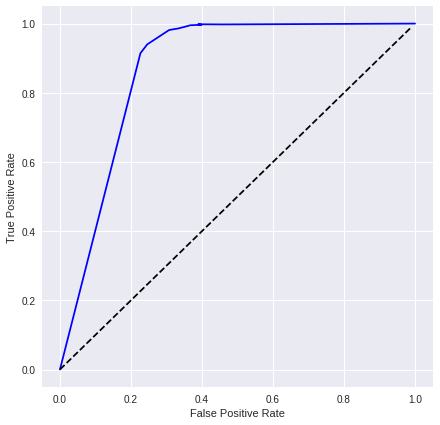

In [40]:
fig = plt.figure(figsize=(7, 7))
sub1 = fig.add_subplot(111)
sub1.set_ylabel('True Positive Rate')
sub1.set_xlabel('False Positive Rate')
sub1.plot(roc2[:, 1], roc2[:, 0], c='b')
sub1.plot(np.arange(0, 1, .01), np.arange(0, 1, .01), c='k', ls='dashed')
plt.show()

In [0]:
from tensorflow.python import pywrap_tensorflow

In [0]:
reader = pywrap_tensorflow.NewCheckPointReader(save_name)

In [0]:
v2sm = reader.get_variable_to_shape_map()